In [1]:
import glob
import random
from PIL import Image
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
from torchvision.models import vgg16
import torchvision.transforms.functional as TVF

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
color_2_index = np.asarray([
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
    ])

class_names = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                'dog', 'horse', 'motorbike', 'person', 'potted-plant',
                'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
path = "data/VOCdevkit/VOC2012/"
seed = 42

img_size = 224
device = "cuda"

In [7]:
class PascalVoc(Dataset):
    def __init__(self, path, img_size):
        self.seg_folder = "SegmentationClass/"
        self.img_folder = "JPEGImages/"
        self.path = path

        self.segmentation_imgs = glob.glob(path + self.seg_folder + "*")
        self.img_size = img_size

        self.mean = torch.tensor([0.485, 0.456, 0.406]).view((1, 1, 3))
        self.std = torch.tensor([0.229, 0.224, 0.225]).view((1, 1, 3))

    def __len__(self):
        return len(self.segmentation_imgs)

    def get_paths(self, idx):
        mask_path = self.segmentation_imgs[idx]

        file_name = mask_path.split("\\")[1]
        img_path = self.path + self.img_folder + file_name
        img_path = img_path.split(".")[0] + ".jpg"

        return (img_path, mask_path)
    
    def load_imgs(self, idx):
        img_path, mask_path = self.get_paths(idx)

        img = Image.open(img_path)
        img = img.resize((self.img_size, self.img_size))

        mask_img = Image.open(mask_path).convert('RGB')
        mask_img = mask_img.resize((self.img_size, self.img_size))

        return (img, mask_img)

    @staticmethod
    def create_label_mask(mask_img):
        mask = np.array(mask_img).astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)

        for idx, label in enumerate(color_2_index):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = idx

        label_mask = label_mask.astype(int)
        return label_mask

    def __getitem__(self, idx):
        img, mask_img = self.load_imgs(idx)

        if random.random() > 0.5:
            img = TVF.hflip(img)
            mask_img = TVF.hflip(mask_img)

        mask_img = PascalVoc.create_label_mask(mask_img)
        mask_img = torch.from_numpy(mask_img).long()
        
        img = TVF.to_tensor(img)
        img = TVF.normalize(img,
                            mean=(0.485, 0.456, 0.406), 
                            std=(0.229, 0.224, 0.225)
                           )

        img = img.to(device)
        mask_img = mask_img.to(device)

        return (img, mask_img)

In [8]:
batch_size = 32
dataset = PascalVoc(path, img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

In [9]:
class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=stride,
                                       padding=1, output_padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x

class fcn_8(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        # Indicies used for FCN-8
        self.fcn_block_indicies = [(0, 17), (17, 24), (24, 31)]
        self.init_vgg()

        self.pool_5_upsample = trans_conv2d(512, 512)
        self.pool_5_bn = nn.BatchNorm2d(512)
        
        self.pool_4_upsample = trans_conv2d(512, 256)
        self.pool_4_bn = nn.BatchNorm2d(512)
        
        self.pool_3_upsample = trans_conv2d(256, 128)
        self.pool_3_bn = nn.BatchNorm2d(256)

        self.upsample_score_1 = trans_conv2d(128, 64)
        self.upsample_score_1_bn = nn.BatchNorm2d(64)
        
        self.upsample_score_2 = trans_conv2d(64, 32)
        self.upsample_score_2_bn = nn.BatchNorm2d(32)

        self.out_conv = nn.Conv2d(32, self.num_classes, kernel_size=1)

    def init_vgg(self):
        model = vgg16(pretrained=True)
        del model.classifier
        model = model.to(device)
        
        self.blocks = []
        
        for block_idx in self.fcn_block_indicies:
            self.blocks.append(model.features[block_idx[0]:block_idx[1]])
        
        # Freezing the VGG weights
        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False        
    
    def forward(self, x):
        x_3 = self.blocks[0](x)
        x_4 = self.blocks[1](x_3)
        x_5 = self.blocks[2](x_4)
        
        score = self.pool_5_upsample(x_5)
        score = self.pool_5_bn(score)
        
        score = score + x_4
        score = self.pool_4_bn(score)
        score = self.pool_4_upsample(score)
        
        score = score + x_3
        score = self.pool_3_bn(score)
        score = self.pool_3_upsample(score)
        
        score = self.upsample_score_1(score)
        score = self.upsample_score_1_bn(score)
        
        score = self.upsample_score_2(score)
        score = self.upsample_score_2_bn(score)
        
        score = self.out_conv(score)
        score = F.log_softmax(score, dim=1)
        return score

In [10]:
def mean_iou(preds, target):
    return (preds & target).float().sum() / (preds | target).float().sum()

In [11]:
torch.manual_seed(seed)
model = fcn_8(len(class_names)).to(device)

In [12]:
num_epochs = 40

lr = 2e-3
wd = 1e-5
gamma = 0.5
step_size = 10

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_fct = nn.NLLLoss()

In [13]:
torch.manual_seed(seed)
model.train()
for epoch in range(1, num_epochs+1):
    loss = 0.0
    iou = 0.0
    
    scheduler.step()
    for _, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        
        y_hat = model(x)
        batch_loss = loss_fct(y_hat, y)
        
        batch_loss.backward()
        optimizer.step()
        
        batch_loss = batch_loss.detach().cpu().numpy()
        loss += batch_loss
        
        preds = torch.argmax(y_hat, dim=1)
        batch_iou = mean_iou(preds, y).detach().cpu().numpy()        
        iou += batch_iou
    
    loss = loss / len(dataloader)
    iou = iou / len(dataloader)
    
    if epoch % 5 == 0:
        print(f"-------Epoch {epoch}-------")
        print(f"Loss : {loss}")
        print(f"Mean IOU: {iou}")

-------Epoch 5-------
Loss : 0.6026998398744542
Mean IOU: 0.42010175371947495
-------Epoch 10-------
Loss : 0.41965569685334747
Mean IOU: 0.5529861223438511
-------Epoch 15-------
Loss : 0.2889559861758481
Mean IOU: 0.6752976684466653
-------Epoch 20-------
Loss : 0.20729167662237002
Mean IOU: 0.7646020676778711
-------Epoch 25-------
Loss : 0.1522005482212357
Mean IOU: 0.8268691754859426
-------Epoch 30-------
Loss : 0.12330793848504192
Mean IOU: 0.8577606146750243
-------Epoch 35-------
Loss : 0.10608943608467994
Mean IOU: 0.8759818841581759
-------Epoch 40-------
Loss : 0.09450563294408114
Mean IOU: 0.8873664976462073


In [14]:
random.seed(seed)
model.eval()

idx = 3
x, _ = dataset[idx]
y, img = dataset.load_imgs(idx)
x = x.unsqueeze(0)

y_hat = model(x)
y_hat = torch.argmax(y_hat, dim=1)[0, :, :]
y_hat = y_hat.detach().cpu().numpy()

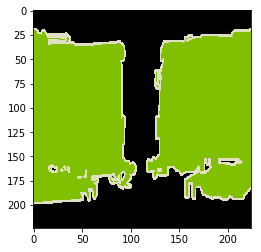

In [15]:
img = dataset.segmentation_imgs[idx]
img = Image.open(img).convert('RGB')
img = img.resize((img_size, img_size))

img = np.array(img)
plt.imshow(img)
plt.show()

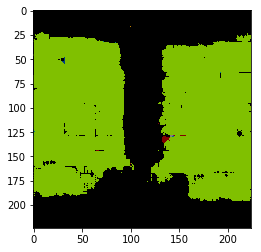

In [16]:
y_hat_mask = np.zeros((img_size, img_size, 3))

for i in range(img_size):
    for j in range(img_size):
        y_hat_mask[i, j, :] = color_2_index[y_hat[i, j]]
        
y_hat_mask = y_hat_mask.astype(int)

plt.imshow(y_hat_mask)
plt.show()

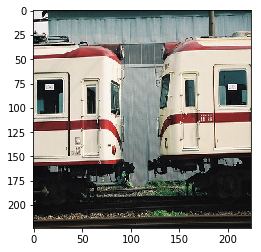

In [17]:
plt.imshow(y)
plt.show()